In [1]:
import torch
from torch import nn 
import numpy as np
from PIL import Image
from skimage.transform import resize
import itertools
import scipy
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

## Headers
Change these cells below to skip certain aspects of the notebook. 

Recommended: Get pretrained models, and disable everything except LOAD_MODEL.

It is also recommended to keep the file hierarchy in the GitHub repository.

In [2]:
LOAD_IMG = False
LOAD_DATA  = False
LOAD_MODEL = True
GENERATE_DATA = False
TRAIN = False

In [3]:
MODEL_PATH = '../models/'
TRAIN_PATH = '../training/'
TEST_PATH = '../test_set_images/'
DATA_PATH = '../data/'

## CUDA
We heavily recommend CUDA. If you don't have it, clone the repository to a server and run it there

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model and Function Definitions

In [5]:
def display_image(img):
    plt.imshow(np.transpose(img,(1,2,0)))

In [6]:
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        self.down_layer1 = nn.Sequential(
            nn.Conv2d(3, 64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        
        self.down_layer2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        
        self.down_layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        
        self.down_layer4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        
        self.bottom_layer = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(512,1024,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(1024,1024,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        )
        
        self.up_layer_1 = nn.Sequential(
            nn.Conv2d(1024,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        )
        
        self.up_layer_2 = nn.Sequential(
            nn.Conv2d(512,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        )
        
        self.up_layer_3 = nn.Sequential(
            nn.Conv2d(256,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        )
        
        self.up_layer_4 = nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(64,1,kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self,x1):
        o1 = self.down_layer1(x1)
        o2 = self.down_layer2(o1)
        o3 = self.down_layer3(o2)
        o4 = self.down_layer4(o3)
        
        b1  = self.bottom_layer(o4)

        u1 = self.up_layer_1(torch.cat([b1,o4], 1))
        u1 = nn.Dropout(0.5)(u1)
        u2 = self.up_layer_2(torch.cat([u1,o3], 1))
        u2 = nn.Dropout(0.5)(u2)
        u3 = self.up_layer_3(torch.cat([u2,o2], 1))
        u3 = nn.Dropout(0.5)(u3)
        u4 = self.up_layer_4(torch.cat([u3,o1], 1))
        return u4

In [7]:
def DiceLoss(y_pred, y_true, eps=1e-6):
    return 1 - (2 * (y_pred * y_true).sum()+eps) / ((y_pred ** 2).sum() + (y_true ** 2).sum() + eps)

In [8]:
if LOAD_MODEL:
    net = UNet()
    net.load_state_dict(torch.load(MODEL_PATH+'model_unet.model')['model_state_dict'])
else:
    net = UNet()
if use_cuda:
    net.cuda()

In [9]:
def batch(images,labels,batch_size):
    k=0
    while k < images.shape[0]:
        yield images[k:min(k+batch_size,images.shape[0])], labels[k:min(k+batch_size,labels.shape[0])]
        k+=batch_size

## Data Generation

In [10]:
#read data
if LOAD_IMG:
    images = np.zeros(shape=(100,3,320,320))
    labels = np.empty(shape=(100,1,320,320))
    for i in tqdm(range(1,101)):
        image = np.array(Image.open(f'{TRAIN_PATH}/images/satImage_{str(i).zfill(3)}.png')).astype(np.float)/255
        label = np.array(Image.open(f'{TRAIN_PATH}/groundtruth/satImage_{str(i).zfill(3)}.png')).astype(np.float)/255
        image = resize(image,(320,320))
        label = resize(label,(320,320))
        image = np.expand_dims(np.transpose(image,(2,0,1)),0)
        label = np.expand_dims(label,0)
        images[i-1,:,:,:] = image
        labels[i-1,:,:,:] = label
    training_images = images[:90]
    training_labels = labels[:90]
    validation_images = images[90:]
    validation_labels = labels[90:]

100%|██████████| 100/100 [00:03<00:00, 30.29it/s]


In [11]:
if GENERATE_DATA:
    np.random.seed(69)
    
    rotations = [0,30,45,60,75]
    no_rotations = 5
    
    translation_range = (0,0)
    no_translations = 1
    
    brightness = [1]
    no_brightness = 1
    
    zooms = [0.75,1]
    no_zooms = 2

    augmented_images = np.zeros(shape=(len(training_images)*no_rotations*no_translations*no_brightness*no_zooms,3,320,320))
    augmented_labels = np.zeros(shape=(len(training_labels)*no_rotations*no_translations*no_brightness*no_zooms,1,320,320))
    k=0
    for i in tqdm(range(training_images.shape[0])):
        for R in rotations:
            for T in range(no_translations):
                for B in range(no_brightness):
                    for zoom in zooms:
                        Ro_r = R
                        Tx_r = np.random.uniform(low=translation_range[0], high=translation_range[1], size=1)[0]
                        Ty_r = np.random.uniform(low=translation_range[0], high=translation_range[1], size=1)[0]
                        Br_r = brightness[B]
                        px = int(320*(1-zoom))//2
                        py = int(320*(1-zoom))//2 

                        zoom_img = np.pad(scipy.ndimage.zoom(np.transpose(images[i],(1,2,0)),(zoom,zoom,1),mode='reflect'),((px,px),(py,py),(0,0)),mode='reflect')
                        rot_img = scipy.ndimage.rotate(zoom_img, Ro_r, reshape=False, mode='reflect')
                        trn_img = scipy.ndimage.shift(rot_img,(Tx_r,Ty_r,0), mode='reflect')

                        zoom_lab = np.pad(scipy.ndimage.zoom(np.transpose(labels[i],(1,2,0)),(zoom,zoom,1),mode='reflect'),((px,px),(py,py),(0,0)),mode='reflect') 
                        rot_lab = scipy.ndimage.rotate(zoom_lab, Ro_r, reshape=False, mode='reflect')
                        trn_lab = scipy.ndimage.shift(rot_lab,(Tx_r,Ty_r,0), mode='reflect')
                        
                        fin_img = np.transpose(Br_r*trn_img,(2,0,1))
                        fin_lab = np.transpose(trn_lab,(2,0,1)) > 0.3
                        augmented_images[k,:,:,:] = np.clip(fin_img,0,1)
                        augmented_labels[k,:,:,:] = fin_lab
                        k+=1
    perm = np.random.permutation(augmented_images.shape[0])
    augmented_images = augmented_images[perm]
    augmented_labels = augmented_labels[perm]

    np.save(f'{DATA_PATH}augmented_images_train_sm',augmented_images)
    np.save(f'{DATA_PATH}augmented_labels_train_sm',augmented_labels)
    np.save(f'{DATA_PATH}validation_images',validation_images)
    np.save(f'{DATA_PATH}validation_labels',validation_labels)

In [7]:
if LOAD_DATA:
    augmented_images_train = np.load(f'{DATA_PATH}augmented_images_train_sm.npy')
    augmented_labels_train = np.load(f'{DATA_PATH}augmented_labels_train_sm.npy')
    validation_images = np.load(f'{DATA_PATH}validation_images.npy')
    validation_labels = np.load(f'{DATA_PATH}validation_labels.npy')

## Training

In [14]:
def train(net,train_data,train_labels,valid_data,valid_labels,epochs,loss,eta,batch_size,weight_decay,eps=1e-5):
    optimizer = torch.optim.Adam(net.parameters(),lr=eta,weight_decay=weight_decay)
    running_loss = 0
    print(f'Starting training with eta={eta} for {epochs} epochs, with batch size {batch_size}')

    #training
    for epoch in tqdm(range(epochs)):
        perm = np.random.permutation(train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        k=0
        print(f'Training for Epoch {epoch+1} starting:')
        net.train()
        loss_train = 0
        for img,lab in batch(train_data,train_labels,batch_size):
            if use_cuda:
                inp = torch.from_numpy(img).float().cuda()
                lab = torch.from_numpy(lab).float().cuda()
            else:
                inp = torch.from_numpy(img).float()
                lab = torch.from_numpy(lab).float()
                
            optimizer.zero_grad()
            inference = net(inp)
            loss_v = loss(inference,lab)
            loss_v.backward()
            optimizer.step()
            
            loss_train += loss_v
            running_loss += loss_v
            k+=1
            if k % 10 == 0:
                print(f'Epoch {epoch+1}, avg running_loss: {running_loss/10}')
                running_loss=0
                k = 0
                
        #validation
        print(f'Validation for Epoch {epoch+1} starting:')
        net.eval()
        with torch.no_grad():
            loss_valid = 0
            for img,lab in batch(valid_data,valid_labels,batch_size):
                if use_cuda:
                    inp = torch.from_numpy(img).float().cuda()
                    lab = torch.from_numpy(lab).float().cuda()
                else:
                    inp = torch.from_numpy(img).float()
                    lab = torch.from_numpy(lab).float()
                inference = net(inp)
                loss_valid += loss(inference,lab)
        print(f'Training loss for {epoch+1}:{loss_train}')
        print(f'Validation loss for {epoch+1}:{loss_valid}')
        
                    
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, MODEL_PATH+'model_unet.model')

In [ ]:
if TRAIN:
    train(net,train_data=augmented_images_train,train_labels=augmented_labels_train,valid_data=validation_images,valid_labels=validation_labels,epochs=100,loss=DiceLoss,eta=3e-6,batch_size=5,weight_decay=1e-7)

### Submission and Model outputs
Change image index and run the following cells to see the outputs of the model

In [ ]:
img_idx = 21

In [11]:
net.eval()
test_img = resize(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255, (320,320))
test_img_n = np.expand_dims(test_img,0)
test_img_n = torch.from_numpy(np.transpose(test_img_n,(0,3,1,2))).float()
if use_cuda:
    out = net(test_img_n.cuda()).detach().cpu().numpy()
else:
    out = net(test_img_n).detach().numpy()

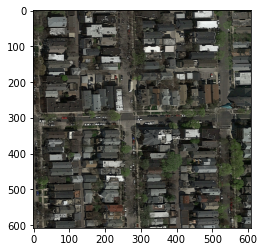

In [12]:
plt.imshow(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255)

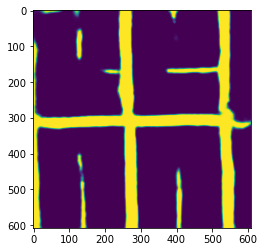

In [13]:
plt.imshow(resize(out[0,0,:,:],(608,608)))

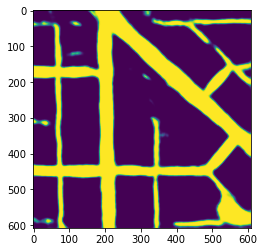

In [130]:
plt.imshow(resize(out[0,0,:,:],(608,608)))

In [15]:
def to_submission(model_output,image_id):
    csv_arr = []
    for i in range(0,model_output.shape[0],16):
        for j in range(0,model_output.shape[1],16):
            prediction = 0
            patch = model_output[j:j+16, i:i+16]
            if np.mean(patch>0.2) > 0.25:
                prediction = 1
            csv_arr.append(["{:03d}_{}_{}".format(image_id,i,j),prediction])
    return csv_arr

In [ ]:
outputs = []
for img_idx in tqdm(range(1,51)):
    net.eval()
    test_img = resize(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255, (320,320))
    test_img_n = np.expand_dims(test_img,0)
    test_img_n = torch.from_numpy(np.transpose(test_img_n,(0,3,1,2))).float()
    if use_cuda:
        out = resize(net(test_img_n.cuda()).detach().cpu().numpy()[0,0,:,:], (608,608))
    else:
        out = resize(net(test_img_n).detach().numpy()[0,0,:,:], (608,608))
    sub_output = to_submission(out,img_idx)
    outputs.append(sub_output)

In [43]:
outputs_np = np.concatenate(outputs,axis=0)
outputs_np = np.concatenate(([['id','prediction']],outputs_np), axis=0)
np.savetxt("submit.csv", outputs_np, delimiter=",", fmt = '%s')